<a href="https://colab.research.google.com/github/iamcerebrocerberus/group_one_image_classification_project_ai/blob/main/GROUP_ONE_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import plot_model
from PIL import Image
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
from tqdm.notebook import tqdm

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!unzip '/content/drive/My Drive/UTKFace.zip'

Streaming output truncated to the last 5000 lines.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327

In [9]:
BASE_DIR = '/content/UTKFace'
gender_labels = []
image_paths = []

image_filenames = os.listdir(BASE_DIR)
random.shuffle(image_filenames)

for image in tqdm(image_filenames):
  image_path = os.path.join(BASE_DIR, image)
  img_components = image.split('_')
  gender_label = int(img_components[1])

  gender_labels.append(gender_label)
  image_paths.append(image_path)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [10]:
print(f"Number of gender_labels: {len(gender_labels)}, Number of image_paths: {len(image_paths)}")

Number of gender_labels: 23708, Number of image_paths: 23708


In [11]:
gender_mapping = {
    1: 'Female',
    0: 'Male',
}

In [12]:
df = pd.DataFrame()
df['image_path'], df['gender'] = image_paths, gender_labels
df.head(10)

,image_path,gender
0,/content/UTKFace/27_1_0_20170117202246110.jpg....,1
1,/content/UTKFace/47_0_3_20170116184916978.jpg....,0
2,/content/UTKFace/28_0_0_20170116232628323.jpg....,0
3,/content/UTKFace/40_0_2_20170104192758426.jpg....,0
4,/content/UTKFace/34_0_1_20170117165134738.jpg....,0
5,/content/UTKFace/38_0_4_20170104202201977.jpg....,0
6,/content/UTKFace/42_0_0_20170117171657481.jpg....,0
7,/content/UTKFace/26_1_3_20170119180953860.jpg....,1
8,/content/UTKFace/7_1_4_20161223225843468.jpg.c...,1
9,/content/UTKFace/75_0_0_20170117192228563.jpg....,0


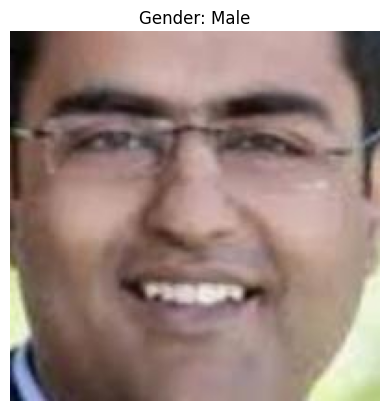

In [13]:
rand_index = random.randint(0, len(image_paths))
gender = df['gender'][rand_index]
IMG = Image.open(df['image_path'][rand_index])
plt.title(f'Gender: {gender_mapping[gender]}')
plt.axis('off')
plt.imshow(IMG)

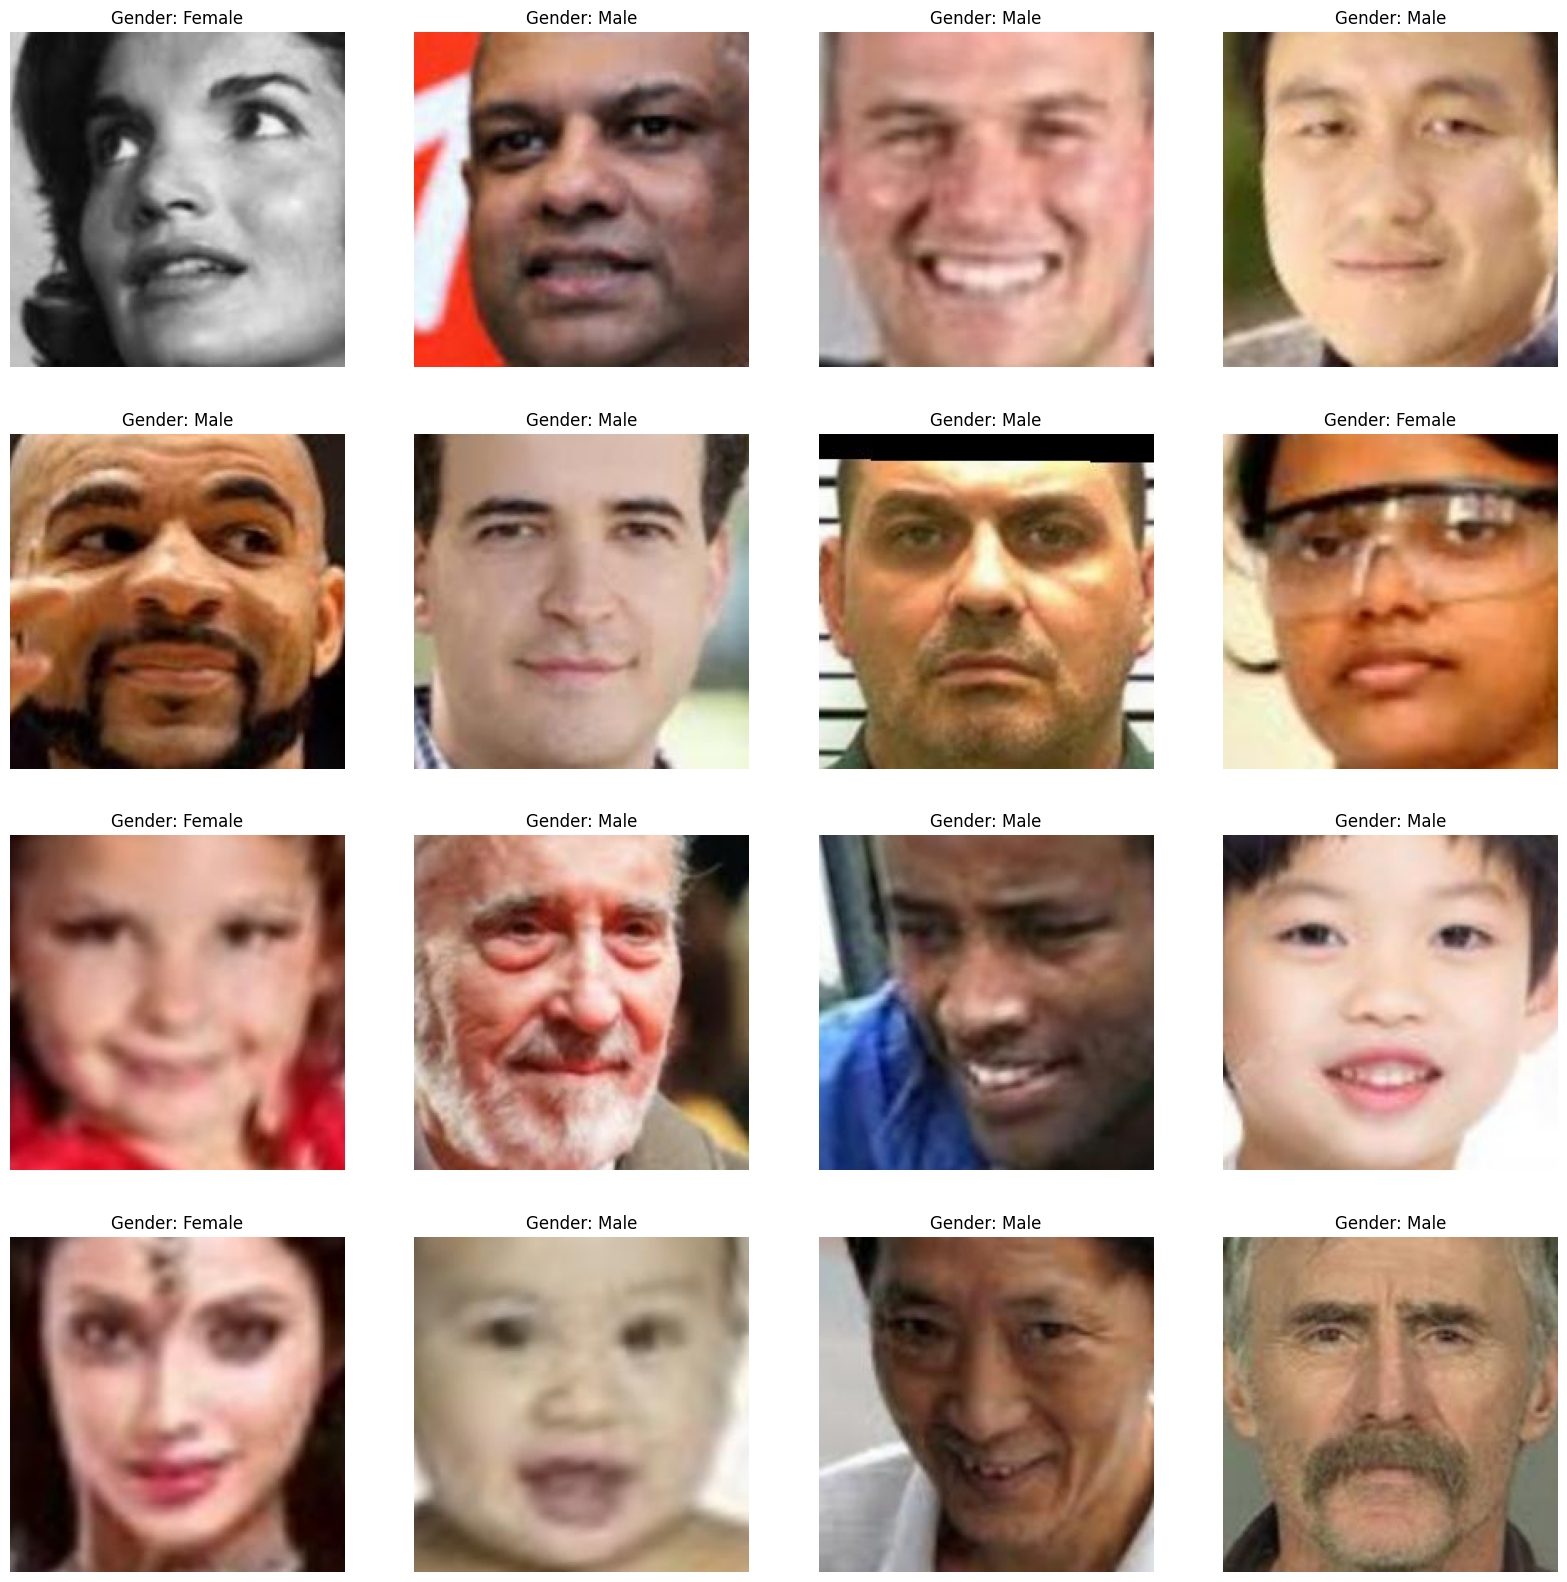

In [14]:
plt.figure(figsize=(20, 20))
samples = df.iloc[0:16]

for index, sample, gender in samples.itertuples():
  plt.subplot(4, 4, index + 1)
  img = load_img(sample)
  img = np.array(img)
  plt.axis('off')
  plt.title(f'Gender: {gender_mapping[gender]}')
  plt.imshow(img)

In [15]:
def extract_image_features(image):
  features = list()

  for image_path in tqdm(image_paths):
        img = load_img(image_path, color_mode="grayscale", target_size=(128, 128))
        img = img_to_array(img)
        features.append(img)

  features = np.array(features)
  features = features.reshape(len(features), 128, 128, 1)
  return features

x = extract_image_features(df['image_path'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [16]:
x.shape

(23708, 128, 128, 1)

In [17]:
x = x / 255.0
y_gender = np.array(df['gender'])
input_shape = (128, 128, 1)

In [18]:
inputs = Input((input_shape))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
max_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max_1)
max_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max_2)
max_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(max_3)
max_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(max_4)

dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)

model = Model(inputs=[inputs], outputs=[output_1])

model.compile(loss=['binary_crossentropy', 'mae'],
              optimizer='adam', metrics=['accuracy'])

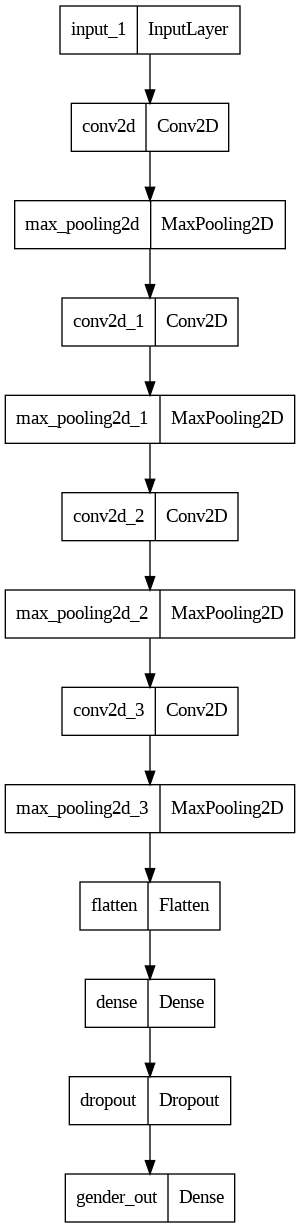

In [19]:
plot_model(model)

In [20]:
history = model.fit(x=x, y=y_gender,
                    batch_size=32, epochs=50, validation_split=0.2)


Epoch 1/50
593/593 [==============================] - 21s 22ms/step - loss: 0.4531 - accuracy: 0.7805 - val_loss: 0.3480 - val_accuracy: 0.8492
Epoch 2/50
593/593 [==============================] - 12s 19ms/step - loss: 0.3227 - accuracy: 0.8583 - val_loss: 0.2971 - val_accuracy: 0.8657
Epoch 3/50
593/593 [==============================] - 12s 19ms/step - loss: 0.2759 - accuracy: 0.8810 - val_loss: 0.2809 - val_accuracy: 0.8728
Epoch 4/50
593/593 [==============================] - 12s 20ms/step - loss: 0.2539 - accuracy: 0.8918 - val_loss: 0.2721 - val_accuracy: 0.8775
Epoch 5/50
593/593 [==============================] - 12s 20ms/step - loss: 0.2312 - accuracy: 0.9019 - val_loss: 0.2649 - val_accuracy: 0.8861
Epoch 6/50
593/593 [==============================] - 12s 20ms/step - loss: 0.2118 - accuracy: 0.9106 - val_loss: 0.2594 - val_accuracy: 0.8817
Epoch 7/50
593/593 [==============================] - 11s 19ms/step - loss: 0.1941 - accuracy: 0.9181 - val_loss: 0.2926 - val_accuracy:

In [22]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


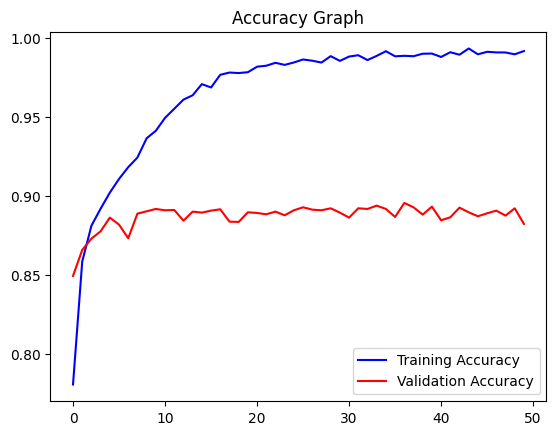

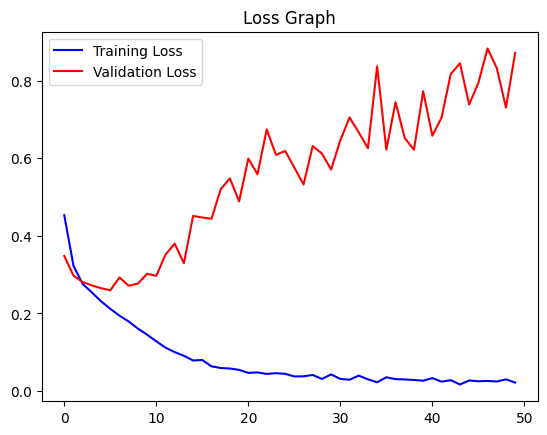

In [23]:
# For accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()  # This creates a new figure for the next plot

# For loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [44]:
def get_image_features(image_path):
    img = load_img(image_path, target_size=(128, 128), color_mode='rgb')  # Ensure this matches your model's expected input
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0) / 255.0  # Normalize the image if your model expects values in [0, 1]
    return img

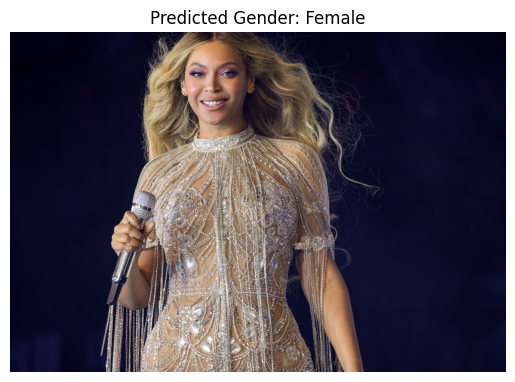

In [47]:


img_to_test = '/content/drive/MyDrive/test_images/beyonceee.jpg'
features = get_image_features(img_to_test)

# Predict gender

gender_prediction = pred[0][0]  # Adjusted based on your model's output

# Determine the predicted gender
gender = gender_mapping[round(gender_prediction)]

# Display the prediction
plt.title(f'Predicted Gender: {gender}')
plt.axis('off')
plt.imshow(np.array(load_img(img_to_test)))
plt.show()